In [1]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip uninstall pyarrow
!pip install pyarrow

Found existing installation: pyarrow 16.1.0
Uninstalling pyarrow-16.1.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/pyarrow-16.1.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pyarrow/*
Proceed (Y/n)? y
  Successfully uninstalled pyarrow-16.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.6.1 requires pyarrow<16.2.0a0,>=16.1.0, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt
pd.set_option("display.max_colwidth", None)

In [4]:
!pip install PyPDF2 tqdm langchain pdf2image pytesseract pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.5 MB/s eta 0:00:00


In [6]:
import PyPDF2
from tqdm import tqdm
from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter

def load_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

# Load the PDF
pdf_path = "/content/1_merged.pdf"  # Replace with your PDF file path
pdf_text = load_pdf(pdf_path)

# Create the knowledge base
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=pdf_text, metadata={"source": pdf_path})
]

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# Split the document
split_docs = text_splitter.split_documents(RAW_KNOWLEDGE_BASE)

print(f"Number of documents after splitting: {len(split_docs)}")

Number of documents after splitting: 71


In [7]:
from tqdm import tqdm
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer

# Assume RAW_KNOWLEDGE_BASE is already defined with your PDF content

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in tqdm(RAW_KNOWLEDGE_BASE, desc="Processing documents"):
    docs_processed += text_splitter.split_documents([doc])

print(f"Number of processed documents: {len(docs_processed)}")

# Initialize the SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # You can change this to your preferred model

# Example: Encode the first processed document (if available)
if docs_processed:
    example_encoding = model.encode(docs_processed[0].page_content)
    print(f"Shape of the encoding for the first document: {example_encoding.shape}")

Processing documents: 100%|██████████| 1/1 [00:00<00:00, 156.14it/s]


Number of processed documents: 68


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Shape of the encoding for the first document: (384,)


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's maximum sequence length: 512


Calculating token lengths: 100%|██████████| 68/68 [00:00<00:00, 337.38it/s]


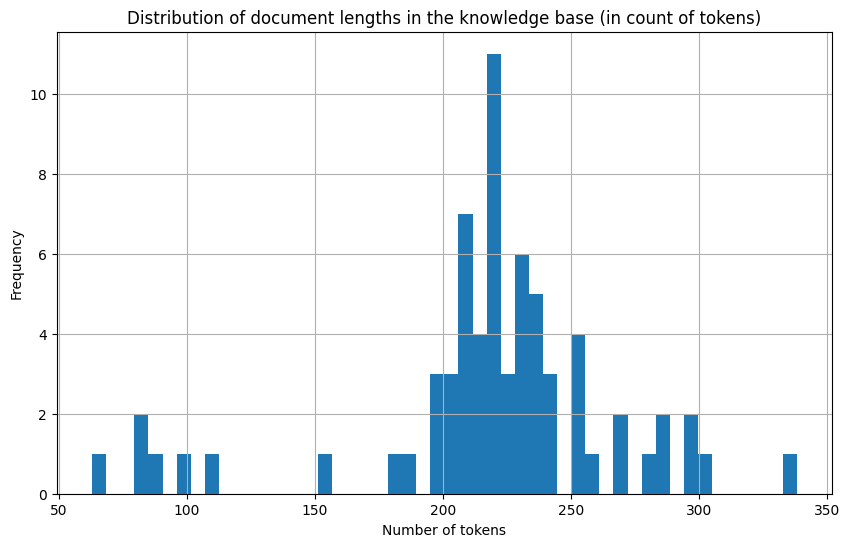

In [8]:
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt

# Assume docs_processed is already defined with your processed PDF content

# Initialize the SentenceTransformer and print its maximum sequence length
model = SentenceTransformer('thenlper/gte-small')
print(f"Model's maximum sequence length: {model.max_seq_length}")

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")

# Calculate token lengths for each processed document
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed, desc="Calculating token lengths")]

# Plot the distribution of document lengths
plt.figure(figsize=(10, 6))
pd.Series(lengths).hist(bins=50)
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.show()

Calculating token lengths: 100%|██████████| 44/44 [00:00<00:00, 434.16it/s]


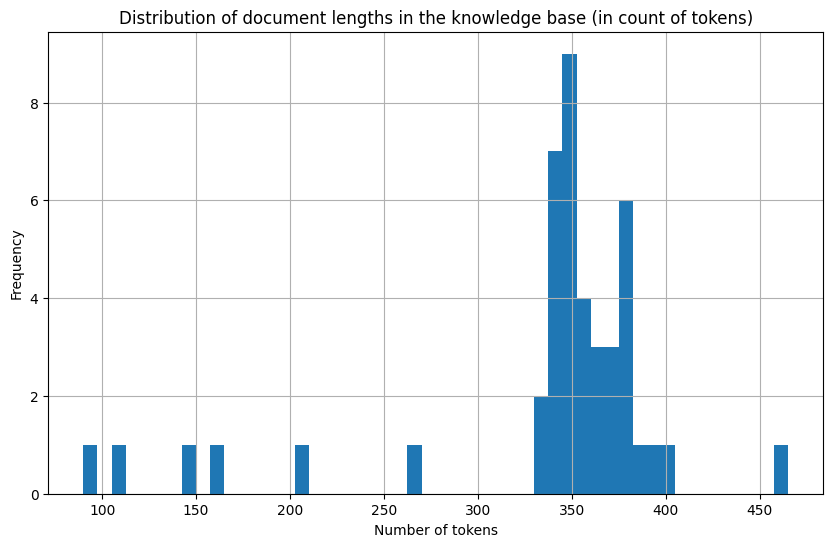

In [9]:
from typing import List, Optional
from tqdm import tqdm
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt

EMBEDDING_MODEL_NAME = "thenlper/gte-small"

MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )
    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)
    return docs_processed_unique

# Assume RAW_KNOWLEDGE_BASE is already defined with your PDF content
docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Visualize the chunk sizes in tokens
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed, desc="Calculating token lengths")]

plt.figure(figsize=(10, 6))
pd.Series(lengths).hist(bins=50)
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.show()

In [10]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import pacmap
import numpy as np
import pandas as pd
import plotly.express as px

# Assuming EMBEDDING_MODEL_NAME and docs_processed are already defined

# Create the embedding model
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True}
)

# Create the vector database
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed,
    embedding_model,
    distance_strategy=DistanceStrategy.COSINE
)

# Embed a user query
user_query = "generate end-sem question paper?"
query_vector = embedding_model.embed_query(user_query)

# Create 2D embeddings for visualization
embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)
embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# Project the embeddings to 2D space
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

# Create a DataFrame for visualization
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[-1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ] + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Create the scatter plot
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    symbol="symbol",
    size="size_col",
    hover_data=["extract"],
    title="Document Embeddings Visualization",
)

# Show the plot
fig.show()

<ipython-input-10-ea17e8009468>:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [11]:
# Step 1: Import necessary libraries
from transformers import AutoTokenizer

# Step 2: Initialize the tokenizer
model_name = "RJ1200/finetund_llama3.2"  # Replace with your actual model name
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Step 3: Define your chat template
chat_template = """
**Course Name:** {course_name}
**Course Code:** {course_code}
**Duration:** {duration}
**Max Marks:** {max_marks}

---

### Questions:

{questions}

---

### Instructions:
- Please answer all questions clearly.
- Indicate your answers with the corresponding question number.
"""

# Sample data for filling in the template
data = {
    "course_name": "PROGRAMMING FOR PROBLEM SOLVING",
    "course_code": "18CS1004",
    "duration": "3 hours",
    "max_marks": 100,
    "questions": """
1. Identify the number of bytes reserved for a float variable in Windows 64-bit applications.
2. Locate the invalid variable(s) in the following declarations:
   - int number;
   - float if;
   - int variable_count;
   - int $main;
3. Define an Algorithm.
4. Name different types of operators included in C.
"""
}

# Step 4: Set the chat template in the tokenizer
tokenizer.chat_template = chat_template

# Step 5: Prepare prompt in chat format
prompt_in_chat_format = chat_template.format(**data)

# Step 6: Now you can apply the chat template
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from langchain.vectorstores import FAISS

# Assuming KNOWLEDGE_VECTOR_DATABASE and user_query are already defined

print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)

print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)

# Model initialization
READER_MODEL_NAME = "RJ1200/finetund_llama3.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

# Updated RAG prompt template
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """You are an AI assistant specializing in analyzing PDF documents. Using the information from the provided PDF context, give a comprehensive answer to the question.
        Respond only to the question asked, ensuring your response is concise and relevant.
        If possible, reference specific page numbers or sections from the PDF.
        If the answer cannot be found in the PDF context, state that the information is not available in the provided documents.""",
    },
    {
        "role": "user",
        "content": """PDF Context:
        {context}
        ---
        Question: {question}""",
    },
]

RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)

print("Updated RAG Prompt Template:")
print(RAG_PROMPT_TEMPLATE)

# Prepare context from retrieved documents
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
context = "\nExtracted PDF content:\n"
context += "".join([f"Section {str(i+1)}:\n" + doc for i, doc in enumerate(retrieved_docs_text)])

# Generate the final prompt
final_prompt = RAG_PROMPT_TEMPLATE.format(question=user_query, context=context)

# Generate the answer
answer = READER_LLM(final_prompt)[0]["generated_text"]

print("\nGenerated Answer:")
print(answer)


Starting retrieval for user_query='generate end-sem question paper?'...


`low_cpu_mem_usage` was None, now set to True since model is quantized.



==================================Top document==================================
b. Compare and contrast Structures with Arrays.  CO6 U 4 
COMPULSORY QUESTION 
24. a. Write a recursive function to return the factorial of all the numbers in a 
one-dimensional array.  CO5 A 6 
 b. Write the C program for bubble sorting. Illustrate the various steps to 
sort the following data in ascending order.  
10, 30, 5, 20, 9, 8  CO3 A 6 
 
 COURSE OUTCOMES 
CO1 Understand the fundamentals of computer and software development process.  
CO2 Identify the data type to represent the real time data representation and operators for computation.  
CO3 Prepare innovative solutions for the problem using branching and looping statements.  
CO4 Decompose a problem into functions and synthesize a complete program using divide and conquer approach.  
CO5 Formulate algorithms and programs using arrays, pointers, and structures.  
CO6 Create a new application software to solve real -world problems.  
 
Assessmen

ValueError: Cannot use apply_chat_template() because tokenizer.chat_template is not set and no template argument was passed! For information about writing templates and setting the tokenizer.chat_template attribute, please see the documentation at https://huggingface.co/docs/transformers/main/en/chat_templating

In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from langchain.vectorstores import FAISS
from ragatouille import RAGPretrainedModel
from typing import List, Tuple, Optional
from langchain.docstore.document import Document as LangchainDocument

# Assuming KNOWLEDGE_VECTOR_DATABASE is already created with your PDF content

# Model initialization
READER_MODEL_NAME = "chuanli11/Llama-3.2-3B-Instruct-uncensored"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=1000,
)

# Initialize reranker
RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

# Updated RAG prompt template
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """You are an AI assistant specializing in analyzing PDF documents. Using the information from the provided PDF context, give a comprehensive answer to the question.
        Respond only to the question asked, ensuring your response is concise and relevant.
        If possible, reference specific page numbers or sections from the PDF.
        If the answer cannot be found in the PDF context, state that the information is not available in the provided documents.""",
    },
    {
        "role": "user",
        "content": """PDF Context:
        {context}
        ---
        Question: {question}""",
    },
]

RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)

def answer_with_rag(
    question: str,
    llm: pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[str]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]  # Keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]
        relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted PDF content:\n"
    context += "".join([f"Section {str(i+1)}:::\n" + doc for i, doc in enumerate(relevant_docs)])
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Generate an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]
    return answer, relevant_docs

# Example usage
question = "generate end-sem question paper?"
answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i+1}------------------------------------------------------------")
    print(doc)

config.json:   0%|          | 0.00/928 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.25G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

=> Retrieving documents...
=> Reranking documents...


/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:15: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


=> Generating answer...
==================================Answer==================================
Based on the provided PDF document, I can help you create a comprehensive end-seminar examination question paper.

**PROGRAMMING FOR PROBLEM SOLVING**

**Course Code:** 18CS1004
**Duration:** 3 hours
**Max. Marks:** 100

**PART-A (10 X 1 = 10 MARKS)**

1. Expand SDLC. (CO1 1)
2. Give the number of bytes reserved for a float variable. (CO2 1)

**PART-B (6 X 3 = 18 MARKS)**

1. Draw the block diagram of computer and describe its components. (CO1 U 3)
2. Compare and contrast ‘keyword’ and ‘identifier’ in C with examples. (CO2 U 3)
3. Write a simple program to find whether a number is odd or even. (CO3 A 3)
4. Write the algorithm for bubble sort program. (CO4 U 3)
5. Describe a function prototype along with its syntax. (CO5 U 3)
6. What is self-referential structure? Explain. (CO6 A 3)

**PART-C (6 X 12 = 72 MARKS)**

(Answer any five questions from Q. No 17 to 23, Q. No 24 is compulsory)

**

In [22]:
# Example usage
question = "generate a question paper of end-sem format?"
answer, relevant_docs = answer_with_rag(question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER)

print("==================================Answer==================================")
print(f"{answer}")


=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


=> Generating answer...
==================================Answer==================================
Based on the provided PDF context, I'll provide a comprehensive answer to the question.

**Question:** Generate a question paper of end-sem format?

**Answer:** 

Here's a sample question paper in end-semester format based on the provided PDF context:

**PROGRAMMING FOR PROBLEM SOLVING**

**END-SEMESTER EXAMINATION**

**SUBJECT CODE:** 18CS1004
**SUBJECT TITLE:** PROGRAMMING IN C
**EXAMINATION DATE:** [Insert Date]
**DURATION:** 3 HOURS

**INSTRUCTIONS TO CANDIDATES:**

* All questions are compulsory.
* Each question carries equal weightage.
* Answer all questions to the best of your ability.
* Use only one side of the page for writing answers.
* Do not copy from any other source.

**PART-A (10 x 1 = 10 MARKS)**

1. **Expand SDLC.** (CO1 R 1)
2. **Give the number of bytes reserved for a float variable.** (CO2 1)

**PART-B (6 x 3 = 18 MARKS)**

1. **Draw the block diagram of computer and d